## Access Hydrological Observations

This notebook is used to demonstrate the access and downloading to csv of Hydrological Observations

The notebook was developed using helpful, open access information provided by (MSC GeoMet services)[https://eccc-msc.github.io/open-data/usage/use-case_oafeat/use-case_oafeat-script_en/]

In [123]:
# Import needed modules

from datetime import date
import yaml

import cartopy.crs as ccrs
from cartopy.io.img_tiles import OSM
from matplotlib import pyplot as plt, dates as mdates
from owslib.ogcapi.features import Features
import numpy as np
import pandas as pd
from tabulate import tabulate
from pathlib import Path
from pprint import pprint
# Plot in notebook
%matplotlib inline

# add autoreload to automatically reload modules when they change
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [42]:
# Set up logger
import logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

## Set needed import for the Bow Watershed

To be moved to config file

In [122]:
# Retrieval of hydrometric stations data
# Read yaml file
config_file = "../settings/bow_watershed_settings.yaml"
with open(config_file, "r") as f:
    config = yaml.safe_load(f)
logger.info(f"Config file: {pprint(config)}")

# Read in the list of hydrometric stations
hydro_stations_df = pd.read_csv(config["hydro_stations_csv"])
search_stations = hydro_stations_df["ID"].tolist()
logger.info(f"Hydrometric stations: {search_stations}")   

# Create an instance of the Features class
oafeat = Features("https://api.weather.gc.ca/")

# Start and end of the time period for which the data will be retrieved
end_date = date.today()
years_to_search = 100
days_to_search = years_to_search * 365

start_date = end_date - pd.Timedelta(days=days_to_search)

output_dir = Path('../output/historic')
output_suffix = '_historic'

retrieve_historic_data(search_stations, start_date, end_date, output_dir, output_suffix,limit=days_to_search)

NameError: name 'pprint' is not defined

In [118]:
# Read station data from csv file
hydro_stations_df = pd.read_csv("../gis_data/hydrometric_Bow.csv")
search_stations = hydro_stations_df["ID"].tolist()

print(f"Hydrometric stations: {search_stations}")

Hydrometric stations: ['05BA001', '05BA002', '05BB001', '05BC001', '05BG006', '05BG010', '05BH004', '05BH005', '05BH013', '05BH015', '05BJ001', '05BJ004', '05BJ010', '05BK001', '05BL007', '05BL012', '05BL013', '05BL014', '05BL019', '05BL022', '05BL023', '05BL027']


In [101]:

def retrieve_real_time_data(stations, start_date, end_date, output_dir, output_suffix='', limit=10000):
    """
    Retrieve real-time hydrometric data for a given time period and save it to CSV files.
    
    Parameters:
    - stations (list): List of hydrometric station IDs.
    - start_date (datetime.date): Start date of the time period.
    - end_date (datetime.date): End date of the time period.
    - output_dir (str or pathlib.Path): Directory path where the output CSV files will be saved.
    - output_suffix (str, optional): Suffix to be added to the output CSV file names. Default is an empty string.
    - limit (int, optional): Maximum number of data points to retrieve per station. Default is 10000.
    
    Returns:
    - None
    
    Raises:
    - ValueError: If no water level data is returned for any station.
    """
    
    time_ = f"{start_date}/{end_date}"
    logger.info(f"Retrieving hydrometric data for the period {time_}")

    # List of stations with no water level data
    stations_without_data = []

    # Data retrieval and creation of the data frames
    for station in stations:

        # Retrieval of water level data
        hydro_data = oafeat.collection_items(
            "hydrometric-realtime",
            limit=limit,
            datetime=time_,
            STATION_NUMBER=station,
        )
        print(hydro_data)
        # Creation of a data frame if there is data for the chosen time period
        if hydro_data["features"]:
            
            # Creation of a dictionary in a format compatible with Pandas
            historical_data_format = [
                {
                    # Note coordinates can be pulled as below, but they are not currently used
                    #"LATITUDE": el["geometry"]["coordinates"][1],
                    #"LONGITUDE": el["geometry"]["coordinates"][0],
                    **el["properties"],
                }
                for el in hydro_data["features"]
            ]
            # Creation of the data frame
            historical_data_df = pd.DataFrame(
                historical_data_format,
                columns=[
                    "STATION_NUMBER",
                    "STATION_NAME",
                    "DATETIME",
                    "LEVEL",
                    "DISCHARGE"
                ],
            )
            
            # Detect and convert data types of columns
            historical_data_df = historical_data_df.infer_objects(copy=False)

            # Creating an index with the date in a datetime format
            historical_data_df["DATETIME"] = pd.to_datetime(
                historical_data_df["DATETIME"]
            )
            historical_data_df.set_index(["DATETIME"], inplace=True, drop=True)
            
            # Output data frame to csv file
            output_csv_path = Path(output_dir,f'{station}{output_suffix}.csv')
            historical_data_df.to_csv(output_csv_path, index=True)

            logger.info(f"Data output to {output_csv_path}")
        
        # If there is no data for the chosen time period, the station
        # will be removed from the dataset
        else:
            stations_without_data.append(station)

    # Removing hydrometric stations without water level data from the station list
    for station in stations_without_data:
        logger.warning(
            f"Station {station} has no water level data for the chosen time period."
        )
        stations.remove(station)

    # Raising an error if no station is left in the list
    if not stations:
        raise ValueError(
            f"No water level data was returned, please check the query."
        )

In [103]:
output_dir = Path('../output/realtime')
output_suffix = '_realtime'
print(stations)
retrieve_real_time_data(stations, start_date, end_date, output_dir, output_suffix)

INFO:__main__:Retrieving hydrometric data for the period 2020-12-01/2020-12-31


[]


ValueError: No water level data was returned, please check the query.

In [116]:
def retrieve_historic_data(stations, bbox, start_date, end_date, output_dir, output_suffix,limit=1000):
    """

    """
    
    time_ = f"{start_date}/{end_date}"
    logger.info(f"Retrieving hydrometric data for the period {time_}")
    # List of stations with no water level data
    stations_without_data = []

    # Data retrieval and creation of the data frames
    for station in stations:

        # Retrieval of water level data
        hydro_data = oafeat.collection_items(
            "hydrometric-daily-mean",
            datetime=time_,
            #bbox=bbox,
            limit=limit,
            STATION_NUMBER=station,
        )

        # Creation of a data frame if there is data for the chosen time period
        if hydro_data["features"]:
            
            # Creation of a dictionary in a format compatible with Pandas
            historical_data_format = [
                {
                    # Note coordinates can be pulled as below, but they are not currently used
                    #"LATITUDE": el["geometry"]["coordinates"][1],
                    #"LONGITUDE": el["geometry"]["coordinates"][0],
                    **el["properties"],
                }
                for el in hydro_data["features"]
            ]
            # Creation of the data frame
            historical_data_df = pd.DataFrame(
                historical_data_format,
                columns=[
                    "STATION_NUMBER",
                    "STATION_NAME",
                    "DATETIME",
                    "LEVEL",
                    "DISCHARGE"
                ],
            )
            
            # Detect and convert data types of columns
            historical_data_df = historical_data_df.infer_objects(copy=False)

            # Creating an index with the date in a datetime format
            historical_data_df["DATETIME"] = pd.to_datetime(
                historical_data_df["DATETIME"]
            )
            historical_data_df.set_index(["DATETIME"], inplace=True, drop=True)
            
            # Output data frame to csv file
            output_csv_path = Path(output_dir,f'{station}{output_suffix}.csv')
            historical_data_df.to_csv(output_csv_path, index=True)

            logger.info(f"Data output to {output_csv_path}")
        
        # If there is no data for the chosen time period, the station
        # will be removed from the dataset
        else:
            stations_without_data.append(station)

    # Removing hydrometric stations without water level data from the station list
    for station in stations_without_data:
        logger.warning(
            f"Station {station} has no water level data for the chosen time period."
        )
        stations.remove(station)

    # Raising an error if no station is left in the list
    if not stations:
        raise ValueError(
            f"No water level data was returned, please check the query."
        )

In [119]:
output_dir = Path('../output/historic')
output_suffix = '_historic'
end_date = date(2023, 12, 31)
start_date = end_date - pd.Timedelta(days=1000)
bbox = [
    -117,
    50,
    -113,
    54
]

retrieve_historic_data(search_stations, bbox, start_date, end_date, output_dir, output_suffix)

INFO:__main__:Retrieving hydrometric data for the period 2021-04-05/2023-12-31


INFO:__main__:Data output to ../output/historic/05BJ004_historic.csv


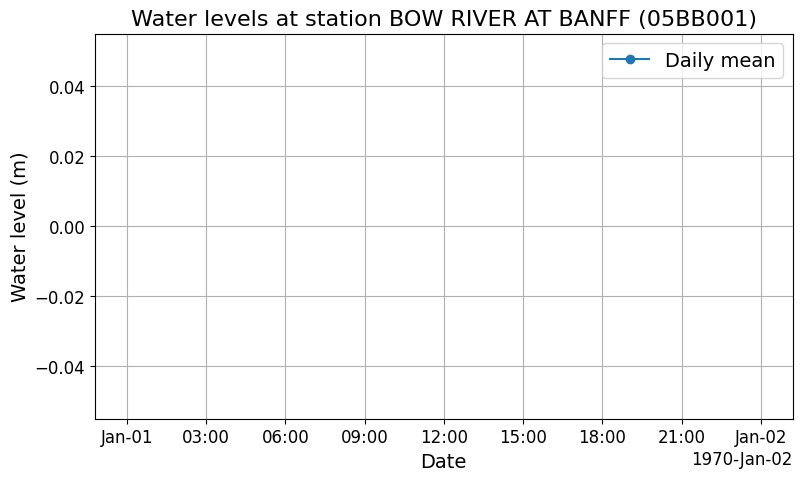

In [6]:
# Creation of an interactive plot with Matplotlib

# Hydrometric station to display on the plot
station_displayed_p = stations[1]

# Function to create a plot for the chosen hydrometric station
def interactive_plot(station):
    # Adjusting font and figure size
    params = {
        "legend.fontsize": "14",
        "figure.figsize": (9, 5),
        "axes.labelsize": "14",
        "axes.titlesize": "16",
        "xtick.labelsize": "12",
        "ytick.labelsize": "12",
    }
    plt.rcParams.update(params)
    
    # Creation of the plot
    fig, ax = plt.subplots()
    line, = plt.plot(
        hydrometric_data[station].index,
        hydrometric_data[station]["LEVEL"],
        marker="o",
        label="Daily mean",
    )
    plt.legend()
    plt.grid(True, which="both")
    ax.set_title(
        fill(
            "Water levels at station {} ({})".format(
                hydrometric_data[station]["STATION_NAME"].iloc[0], station
            ), 60
        )
    )
    ax.set_ylabel("Water level (m)")
    ax.set_xlabel("Date")

    # Modification of the x axis ticks and tick labels
    locator = mdates.AutoDateLocator()
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)

    # Creation of the annotations to display on hover
    annot = ax.annotate(
        "",
        xy=(0, 0),
        xytext=(-60, -40),
        textcoords="offset points",
        bbox=dict(boxstyle="round", fc="w"),
        arrowprops=dict(arrowstyle="->"),
    )
    annot.set_visible(False)

    return line, annot, ax, fig


# Choosing the hydrometric stations to create the plot
line, annot, ax, fig = interactive_plot(station_displayed_p)


# Updating the annotation with the data point information
def update_annot(ind):
    # Identifying the annotation to display
    x, y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    
    # Adding text to the annotation (date and water level)
    date_x = x[ind["ind"]][0]
    level_y = round(y[ind["ind"]][0], 2)
    text = "{}\nDaily mean: {} m".format(date_x, level_y)
    annot.set_text(text)
    
    # Setting annotation transparency
    annot.get_bbox_patch().set_alpha(0.8)


# Display of annotations on hover
def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


# Adding the feature that displays annotations on hover               
fig.canvas.mpl_connect("motion_notify_event", hover)

plt.show()

/var/folders/cf/h3xm_pj57nxdnm6lk83rzxt9jt0gpj/T/ipykernel_14987/498741574.py:47: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(
/var/folders/cf/h3xm_pj57nxdnm6lk83rzxt9jt0gpj/T/ipykernel_14987/498741574.py:47: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  ax.plot(


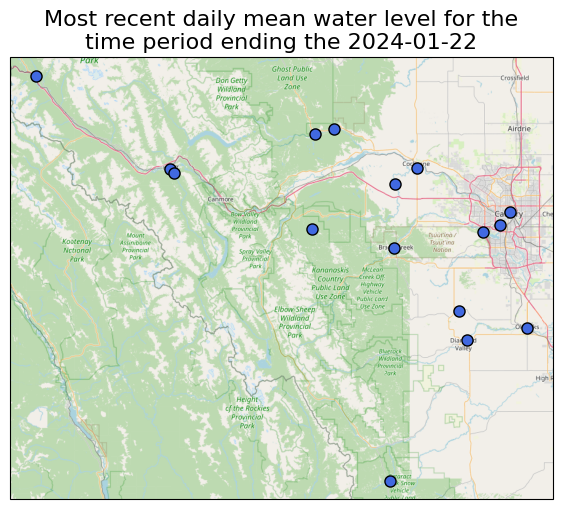

In [7]:
# Creation of the interactive map

# Lists of positions and labels
labels = []
all_lat = []
all_lon = []
for station in stations:
    latest_data = hydrometric_data[station].iloc[-1]
    labels.append(
        f"{hydrometric_data[station]['STATION_NAME'].iloc[0]}\n"
        + f"Station ID: {latest_data.STATION_NUMBER}\n"
        + f"Date: {latest_data.name}\n"
        + f"Water level: {round(latest_data.LEVEL, 2)} m"
    )
    all_lat.append(latest_data.LATITUDE)
    all_lon.append(latest_data.LONGITUDE)

# List for keeping track of all annotations
annotations = [None for label in labels]

# Defining size of markers
markersize = 8
markersize_inches = markersize / 72.0

# Setting up figure
tiler = OSM()
fig = plt.figure(figsize=(7, 7))
ax = plt.axes(projection=tiler.crs)
ax.set_title(fill(
    "Most recent daily mean water level for the "
    + f"time period ending the {end_date}", 45))

# Setting the extent to see adequately all data points
ax.set_extent(
    [
        min(all_lon) * 1.001,
        max(all_lon) * 0.999,
        min(all_lat) * 0.999,
        max(all_lat) * 1.001,
    ]
)

# Adding a basemap from Open Street Map
ax.add_image(tiler, 9)

# Adding data points
ax.plot(
    all_lon,
    all_lat,
    "bo",
    marker="o",
    mec="k",
    color="RoyalBlue",
    ms=markersize,
    transform=ccrs.Geodetic(),
)

# Figure coordinates in inches
trans = ax.transData + fig.dpi_scale_trans.inverted()


# Function for checking mouse coordinates and annotating
def on_move(event):
    if event.inaxes:
        # Transforming the coordinates in the same projection as the plot
        xproj, yproj = zip(
            *[
                ax.projection.transform_point(x, y, src_crs=ccrs.Geodetic())
                for x, y in zip(all_lon, all_lat)
            ]
        )
        # Event coordinates in inches
        x0, y0 = trans.transform((event.xdata, event.ydata))
        # Data points coordinates in inches
        xfig, yfig = zip(
            *[trans.transform((x, y)) for x, y in zip(xproj, yproj)]
        )
        # Distance of the mouse from the data point
        dists = [math.sqrt((x - x0) ** 2 + (y - y0) ** 2) for x, y in zip(
            xfig, yfig
        )]
        
        # Displaying annotations on hover
        for n, (x, y, dist, label) in enumerate(
                zip(xproj, yproj, dists, labels)
        ):
            if dist < markersize_inches and annotations[n] is None:
                annotations[n] = ax.annotate(
                    label,
                    [x, y],
                    xycoords="data",
                    xytext=(10, 10),
                    textcoords="offset points",
                    ha="center",
                    va="bottom",
                    bbox=dict(
                        facecolor="white",
                        edgecolor="black",
                        boxstyle="round"
                    ),
                    zorder=10,
                )
                fig.canvas.draw()

            elif dist > markersize_inches and annotations[n] is not None:
                annotations[n].remove()
                annotations[n] = None
                fig.canvas.draw()


# Connecting the event handler
cid = fig.canvas.mpl_connect("motion_notify_event", on_move)

plt.show()